# 🩺 Stroke Prediction: End-to-End Machine Learning Pipeline

# 1. Import Libraries
Import all necessary libraries for data processing, modeling, and visualization

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix,roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import shap
import joblib
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Meta Information

**Files:**
- `train.csv`: Data containing all available features and the stroke response.
- `test.csv`: Unseen stroke patients with all available predictors but missing stroke. Used for model prediction.
- `sample_submission.csv`: A sample submission file in the correct format.

**Data Dictionary:**
- `id`: *Integer* — Unique identifier for each record.
- `gender`: *String* — Gender of the patient (`Male`, `Female`).
- `age`: *Float* — Age of the patient in years.
- `hypertension`: *Integer* — Indicates whether the patient has hypertension (`0`: No, `1`: Yes).
- `heart_disease`: *Integer* — Indicates whether the patient has heart disease (`0`: No, `1`: Yes).
- `ever_married`: *String* — Marital status of the patient (`Yes`, `No`).
- `work_type`: *String* — Type of employment (`Private`, `Self-employed`, `Govt_job`, `Children`, etc.).
- `Residence_type`: *String* — Type of residence (`Urban`, `Rural`).
- `avg_glucose_level`: *Float* — Average glucose level of the patient (mg/dL).
- `bmi`: *Float* — Body Mass Index (BMI) of the patient.
- `smoking_status`: *String* — Smoking status (`never smoked`, `formerly smoked`, `smokes`, `Unknown`).
- `stroke`: *Integer* — Target variable indicating whether the patient had a stroke (`0`: No, `1`: Yes). **[TARGET]**

# 3. Load Data
 Load training and test datasets

In [6]:
test[test["id"]==1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,Female,40.0,0,0,Yes,Private,Urban,94.65,34.7,never smoked


In [2]:
base_path="../data/raw"
def read_data(base_path,file_name):
    """
    Reads a CSV file from the specified base path and returns a DataFrame.
    """
    df=pd.read_csv(f'{base_path}/{file_name}')
    return df

In [3]:
# Load the training data
train = read_data(base_path, 'train.csv')
# Load the test data
test = read_data(base_path, 'test.csv')

In [5]:
pd.get_dummies(test[test["id"]==1], columns=['gender', 'work_type', 'smoking_status'], drop_first=False)

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,work_type_Private,smoking_status_never smoked
0,1,40.0,0,0,Yes,Urban,94.65,34.7,True,True,True


# 4. Exploratory Data Analysis (EDA)

### 4.1 Check dataset shape

In [7]:
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Train Data Shape: (12243, 12)
Test Data Shape: (3061, 11)


### 4.2 Check dataset metadata
Display data types and missing values

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12243 non-null  int64  
 1   gender             12243 non-null  object 
 2   age                12243 non-null  float64
 3   hypertension       12243 non-null  int64  
 4   heart_disease      12243 non-null  int64  
 5   ever_married       12243 non-null  object 
 6   work_type          12243 non-null  object 
 7   Residence_type     12243 non-null  object 
 8   avg_glucose_level  12243 non-null  float64
 9   bmi                12243 non-null  float64
 10  smoking_status     12243 non-null  object 
 11  stroke             12243 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


### 4.3 Statistical Summary
Show summary statistics for numerical features

In [9]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.00000
mean,6122.000000,41.344951,0.049416,0.023279,88.820804,28.074400,0.04133
std,3534.394007,21.518463,0.216744,0.150793,24.957986,6.707892,0.19906
min,1.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.00000
25%,3061.500000,25.000000,0.000000,0.000000,74.880000,23.500000,0.00000
50%,6122.000000,43.000000,0.000000,0.000000,85.030000,27.600000,0.00000
75%,9182.500000,57.000000,0.000000,0.000000,96.840000,31.900000,0.00000
max,12243.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.00000


### 4.4 View Sample Data
Display the first few rows of the training data

In [10]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1


# 4.5 Data Profiling
 Generate an automated profiling report for EDA

In [11]:
profile = ProfileReport(train, title="Stroke Prediction Dataset Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 208.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.6 Target Variable Distribution
 Visualize the distribution of the target variable (stroke)

In [12]:
train['stroke'].value_counts()

stroke
0    11737
1      506
Name: count, dtype: int64

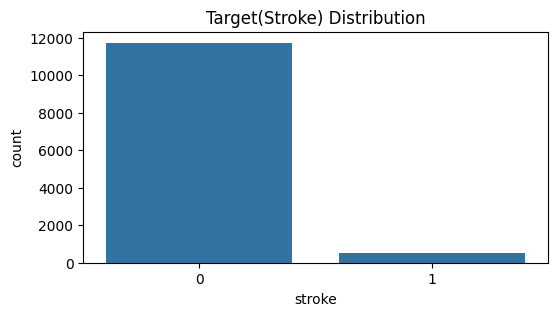

In [ ]:
# Check class imbalance
plt.figure(figsize=(6, 3))
sns.countplot(x='stroke', data=train)
plt.title("Target(Stroke) Distribution")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

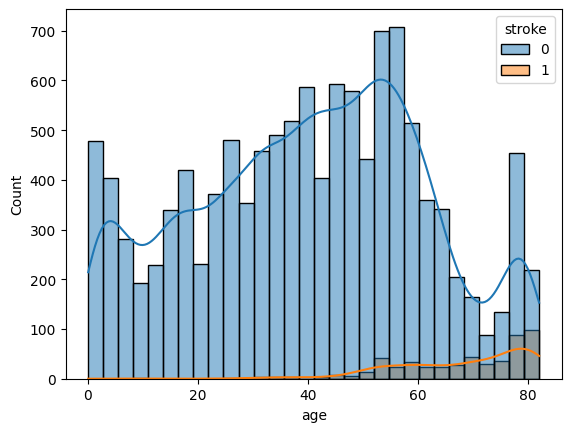

In [40]:
sns.histplot(data=train, x='age', hue='stroke', kde=True)

<Axes: xlabel='stroke', ylabel='avg_glucose_level'>

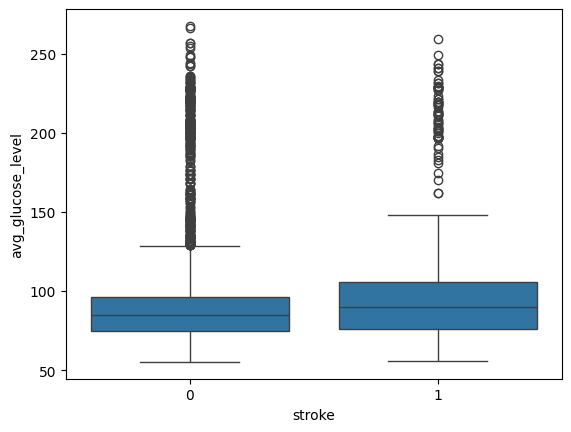

In [39]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=train)

<Axes: xlabel='stroke', ylabel='bmi'>

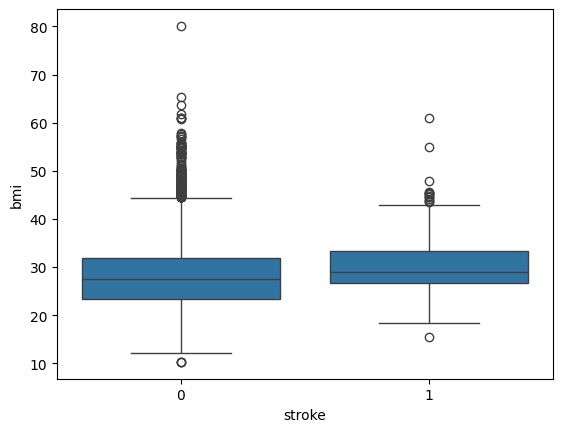

In [41]:
sns.boxplot(x='stroke', y='bmi', data=train)

In [47]:
train.isnull().sum()
# test.isnull().sum()



id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# 6. Data Preprocessing
 **Handle missing values in 'bmi' and 'smoking_status'**

In [48]:
train['is_train'] = 1
test['is_train'] = 0
full_data = pd.concat([train, test], ignore_index=True)

In [49]:
full_data['bmi'] = full_data['bmi'].fillna(full_data['bmi'].median())

In [50]:
binary_cols = ['ever_married', 'Residence_type']
multi_cols = ['gender', 'work_type', 'smoking_status']

In [51]:
for col in binary_cols:
    full_data[col] = full_data[col].map({'Yes': 1, 'No': 0, 'Urban': 1, 'Rural': 0})

In [52]:
full_data = pd.get_dummies(full_data, columns=multi_cols, drop_first=True)

In [54]:
train = full_data[full_data['is_train'] == 1].drop(['is_train'], axis=1)
test = full_data[full_data['is_train'] == 0].drop(['is_train', 'stroke'], axis=1)

In [56]:
# train['bmi'].fillna(train['bmi'].median(), inplace=True)
# train['smoking_status'].fillna('Unknown', inplace=True)

# test['bmi'].fillna(test['bmi'].median(), inplace=True)
# test['smoking_status'].fillna('Unknown', inplace=True)

# 7. Feature Engineering
**Encode categorical variables using LabelEncoder**

In [57]:
# cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
# encoder = LabelEncoder()
# for col in cat_features:
#     train[col] = encoder.fit_transform(train[col])
#     test[col] = encoder.transform(test[col])

# 8. Feature Selection
**Select features for modeling (exclude 'id' and 'stroke')**

In [58]:
features = [col for col in train.columns if col not in ['id', 'stroke']]
X = train[features]
y = train['stroke']

# 9. Handle Class Imbalance
**Apply SMOTE to balance the target classes**

In [59]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# --- K-Fold Cross-Validation for All Models ---

In [20]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='f1')
    print(f"{name} Cross-validated F1-scores: {cv_scores}")
    print(f"{name} Mean CV F1-score: {np.mean(cv_scores):.4f}\n")

Logistic Regression Cross-validated F1-scores: [0.83189927 0.82543058 0.82385166 0.82919584 0.84114475]
Logistic Regression Mean CV F1-score: 0.8303

Random Forest Cross-validated F1-scores: [0.95745127 0.9541517  0.95149726 0.96153038 0.95546728]
Random Forest Mean CV F1-score: 0.9560

XGBoost Cross-validated F1-scores: [0.94752433 0.94756791 0.94659378 0.95574846 0.94743455]
XGBoost Mean CV F1-score: 0.9490

[LightGBM] [Info] Number of positive: 9390, number of negative: 9389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500027 -> initscore=0.000107
[LightGBM] [Info] Start training from score 0.000107
[LightGBM] [Info] Number of posit

# 10. Visualize Resampled Distribution
**Plot the distribution after SMOTE resampling**

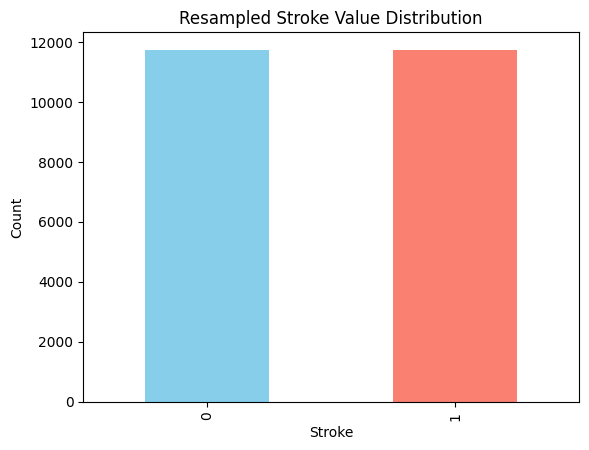

In [22]:
y_resampled.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Resampled Stroke Value Distribution')
plt.show()

# 12. Train/Validation Split
**Split the resampled data into training and validation sets**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 13. Model Training Functions
**Define reusable functions for model training and evaluation**

**13.1 Model training function**

In [24]:
def scale_features(X_train, X_val, X_test=None):
    """
    Scales features using StandardScaler. Returns scaled train, val, and optionally test sets.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled
    return X_train_scaled, X_val_scaled

In [25]:
def model_training(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

**13.2 Model Evaluation function**

In [26]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    print("Validation F1-Score:", f1_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    return f1, report, cm

**13.3 Confusion matrix function**

In [27]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap='Blues'):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

**13.4 Hyper training function**

In [29]:
def hyperparameter_tuning_lr(X_train, y_train):
    params = {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 500, 1000]
    }
    grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    print("Best Logistic Regression parameters:", grid.best_params_)
    return grid.best_estimator_

def hyperparameter_tuning_rf(X_train, y_train):
    params = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    print("Best Random Forest parameters:", grid.best_params_)
    return grid.best_estimator_

def hyperparameter_tuning_xgb(X_train, y_train):
    params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid=params, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    print("Best XGBoost parameters:", grid.best_params_)
    return grid.best_estimator_

def hyperparameter_tuning_lgb(X_train, y_train):
    params = {
        'num_leaves': [31, 50],
        'max_depth': [5, 10, -1],
        'learning_rate': [0.01, 0.1]
    }
    grid = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid=params, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    print("Best LightGBM parameters:", grid.best_params_)

**13.5 Final data save function**

In [30]:
def generate_final_predictions(model, test_features, model_name):
    """
    Generate predictions on the test set and save the submission file.
    """
    predictions = model.predict(test_features)
    submission = pd.DataFrame({
        'id': test['id'],
        'stroke': predictions
    })
    submission.to_csv(f'submission_{model_name}.csv', index=False)
    print(f"Submission file saved as 'submission_{model_name}.csv'")
    
    return submission["stroke"].value_counts()

**13.6 Model save function**

In [179]:
model_dir = "../models"
def save_model(model, model_name):
    joblib.dump(model, f'{model_dir}/{model_name}.pkl')
    print(f"Model saved as {model_name}.pkl")

**13.7 ROC AUC plot function**

In [180]:
def roc_auc_plot(y_true, y_scores):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    print("ROC AUC Score:", roc_auc)

In [181]:
# estimators = [
#     ('lgb', lgb_model),
#     ('xgb', xgb_model)
# ]
# stack_model = StackingClassifier(estimators=estimators, final_estimator=lgb.LGBMClassifier(), cv=5)

# # 9. Cross-Validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(stack_model, X_resampled, y_resampled, cv=kf, scoring='f1')
# print("Cross-validated F1-scores:", cv_scores)
# print("Mean CV F1-score:", np.mean(cv_scores))

# # 10. Train/Validation Split
# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# stack_model.fit(X_train, y_train)
# y_pred = stack_model.predict(X_val)

# # 11. Evaluation
# print("Validation F1-Score:", f1_score(y_val, y_pred))
# print(classification_report(y_val, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix')
# plt.show()

# # SHAP Feature Importance (for LightGBM)
# explainer = shap.TreeExplainer(stack_model.named_estimators_['lgb'])
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

# # 12. Final Training on Full Resampled Data
# stack_model.fit(X_resampled, y_resampled)
# final_predictions = stack_model.predict(test[features])


In [182]:
# # 7. XGBoost Model Training
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# xgb_model.fit(X_train, y_train)
# y_pred = xgb_model.predict(X_val)

# # 8. Evaluation
# print("XGBoost Validation F1-Score:", f1_score(y_val, y_pred))
# print(classification_report(y_val, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('XGBoost Confusion Matrix')
# plt.show()

# # SHAP Feature Importance for XGBoost
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

# # 9. Final Training on Full Resampled Data
# xgb_model.fit(X_resampled, y_resampled)
# final_predictions = xgb_model.predict(test[features])

In [183]:
model_results = []

# 14. Model Training and Evaluation

**14.1 Logistic Regression**

In [184]:
X_train_scaled,X_val_scaled,X_test = scale_features(X_train, X_val,test[features])

Validation F1-Score: 0.67429055484964
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2307
           1       0.51      1.00      0.67      2388

    accuracy                           0.51      4695
   macro avg       0.25      0.50      0.34      4695
weighted avg       0.26      0.51      0.34      4695



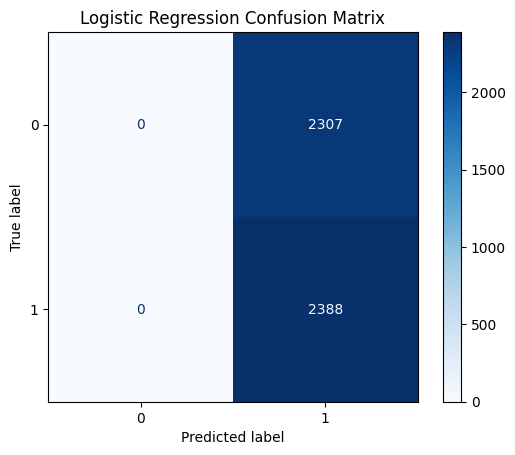

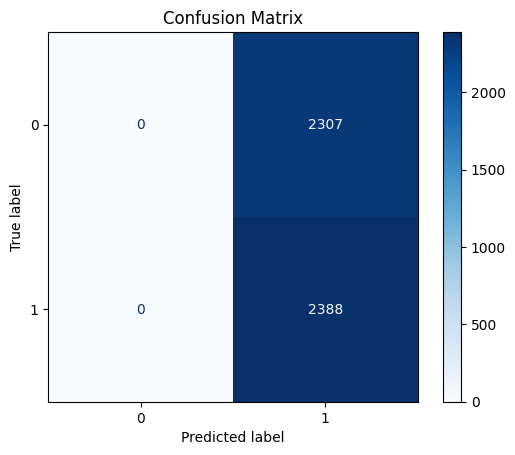

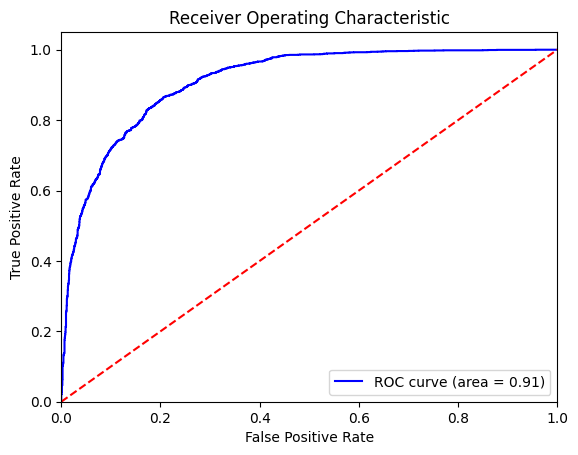

ROC AUC Score: 0.9113385886229298


In [185]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_trained = model_training(lr_model, X_train_scaled, y_train)
# lr_final_predictions = generate_final_predictions(lr_trained, X_test, "lr_model")
lr_f1, lr_report, lr_cm = evaluate_model(lr_trained, X_val, y_val)
model_results.append({
    "Model": "Logistic Regression",
    "F1 Score": lr_f1,
    "ROC AUC": roc_auc_score(y_val, lr_trained.predict_proba(X_val_scaled)[:, 1])
})
plot_confusion_matrix(lr_cm, title='Logistic Regression Confusion Matrix', cmap='Blues')
roc_auc_plot(y_val, lr_trained.predict_proba(X_val_scaled)[:, 1])
# save_model(lr_trained, 'stroke_lr_model')

**14.2 Random Forest : Train and evaluate Random Forest model**


Validation F1-Score: 0.9562706270627063
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2307
           1       0.94      0.97      0.96      2388

    accuracy                           0.95      4695
   macro avg       0.96      0.95      0.95      4695
weighted avg       0.96      0.95      0.95      4695



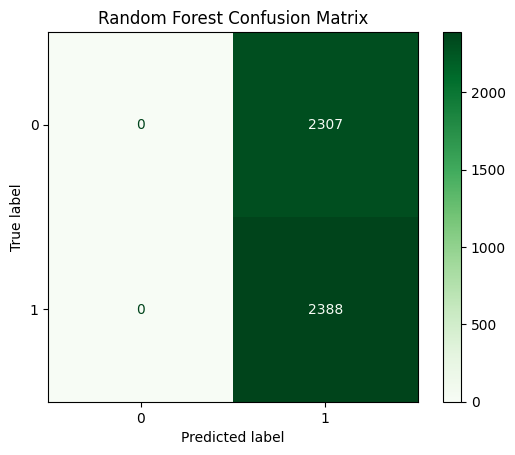

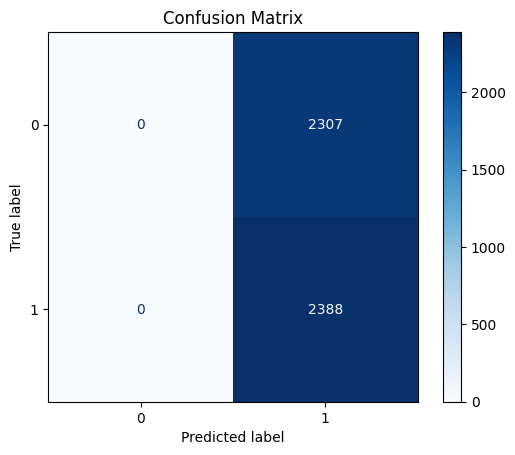

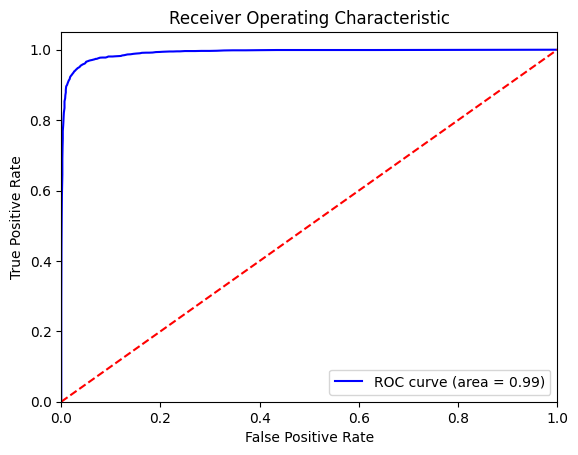

ROC AUC Score: 0.9917349716361027
Model saved as stroke_rf_model.pkl


In [186]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_trained = model_training(rf_model, X_train, y_train)
rf_f1, rf_report, rf_cm = evaluate_model(rf_trained, X_val, y_val)
model_results.append({
    "Model": "Random Forest",
    "F1 Score": rf_f1,
    "ROC AUC": roc_auc_score(y_val, rf_trained.predict_proba(X_val)[:, 1])
})
plot_confusion_matrix(cm,title='Random Forest Confusion Matrix', cmap='Greens')
roc_auc_plot(y_val, rf_trained.predict_proba(X_val)[:, 1])
save_model(rf_trained, 'stroke_rf_model')

**14.3 XGBoost : Train and evaluate XGBoost model**


Validation F1-Score: 0.9475864926455355
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2307
           1       0.94      0.96      0.95      2388

    accuracy                           0.95      4695
   macro avg       0.95      0.95      0.95      4695
weighted avg       0.95      0.95      0.95      4695



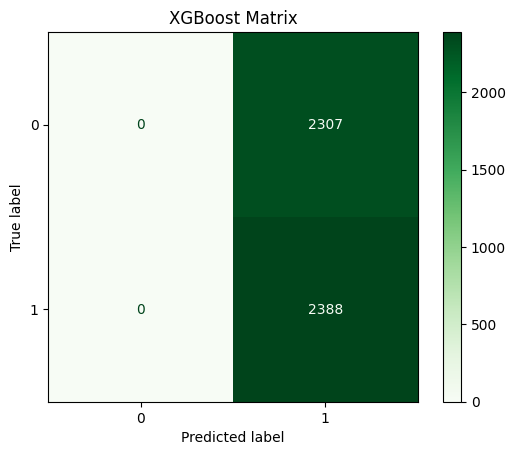

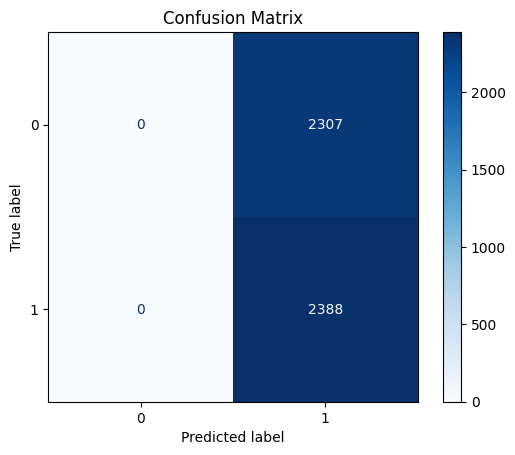

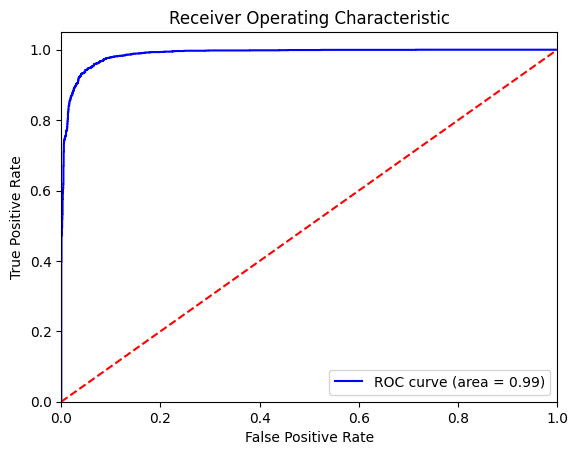

ROC AUC Score: 0.9882095421479599
Model saved as stroke_xgb_model.pkl


In [187]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_trained = model_training(xgb_model, X_train, y_train)
xgb_f1, xgb_report, xgb_cm = evaluate_model(xgb_trained, X_val, y_val)
model_results.append({
    "Model": "XGBoost",
    "F1 Score": xgb_f1,
    "ROC AUC": roc_auc_score(y_val, xgb_trained.predict_proba(X_val)[:, 1])
})
plot_confusion_matrix(cm,title='XGBoost Matrix', cmap='Greens')
roc_auc_plot(y_val, xgb_trained.predict_proba(X_val)[:, 1])
save_model(xgb_trained, 'stroke_xgb_model')

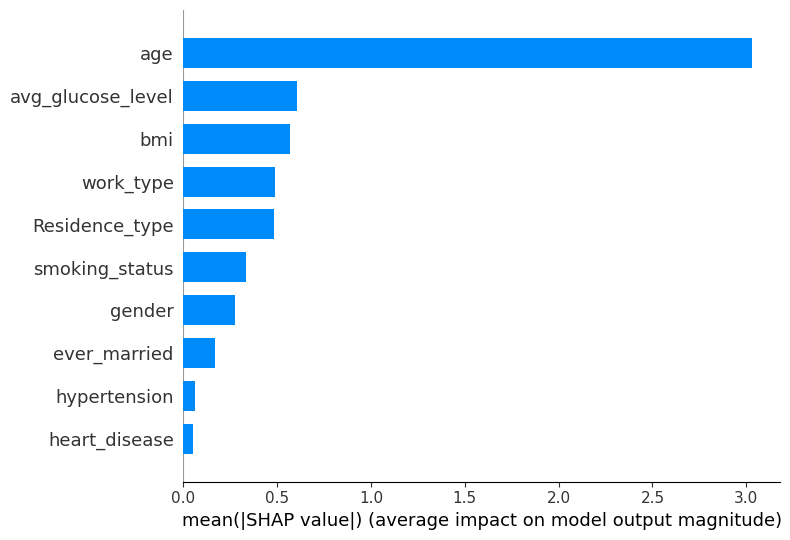

In [188]:
# SHAP Feature Importance for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

**14.3 LightGBM : Train and evaluate LightGBM model**


[LightGBM] [Info] Number of positive: 9349, number of negative: 9430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497843 -> initscore=-0.008627
[LightGBM] [Info] Start training from score -0.008627
Validation F1-Score: 0.9433416046319272
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2307
           1       0.93      0.96      0.94      2388

    accuracy                           0.94      4695
   macro avg       0.94      0.94      0.94      4695
weighted avg       0.94      0.94      0.94      4695



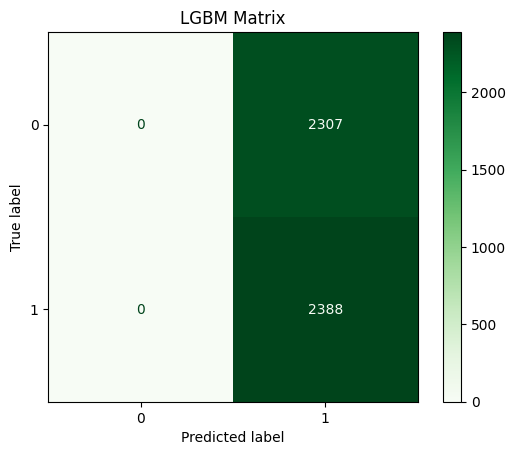

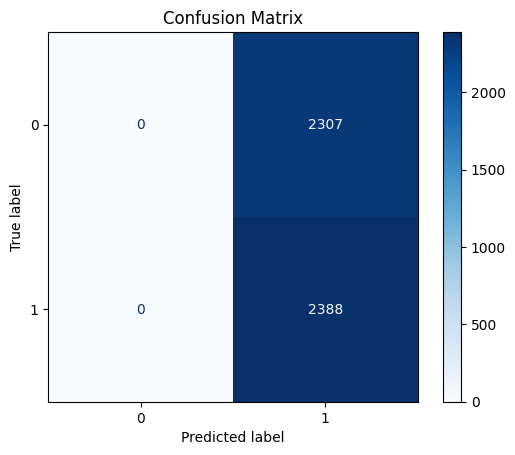

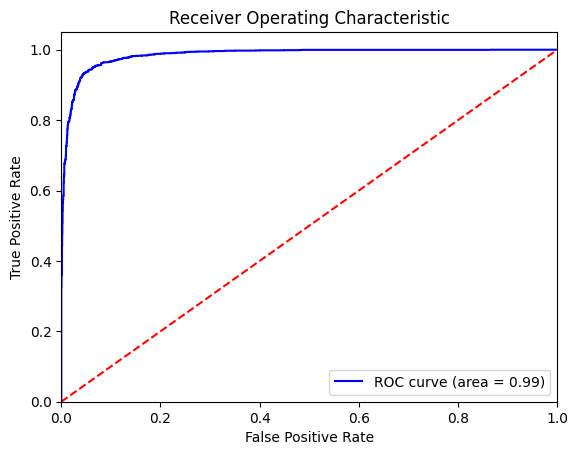

ROC AUC Score: 0.9851238383798779
Model saved as stroke_lgb_model.pkl


In [189]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_trained = model_training(lgb_model, X_train, y_train)
lgb_f1, lgb_report, lgb_cm = evaluate_model(lgb_trained, X_val, y_val)
model_results.append({
    "Model": "LightGBM",
    "F1 Score": lgb_f1,
    "ROC AUC": roc_auc_score(y_val, lgb_trained.predict_proba(X_val)[:, 1])
})
plot_confusion_matrix(cm,title='LGBM Matrix', cmap='Greens')
roc_auc_plot(y_val, lgb_trained.predict_proba(X_val)[:, 1])
save_model(lgb_trained, 'stroke_lgb_model')

In [190]:
# Display summary table
summary_df = pd.DataFrame(model_results)
display(summary_df)

,Model,F1 Score,ROC AUC
0,Logistic Regression,0.674291,0.911339
1,Random Forest,0.956271,0.991735
2,XGBoost,0.947586,0.988210
3,LightGBM,0.943342,0.985124


## 🏁 Conclusion

Based on the model comparison summary:

- **Random Forest** achieved the highest F1 Score (0.956) and ROC AUC (0.992), indicating excellent performance on both precision/recall balance and overall discrimination.
- **XGBoost** and **LightGBM** also performed very well, with F1 Scores above 0.94 and ROC AUCs above 0.98, making them strong alternatives.
- **Logistic Regression** performed reasonably (F1 Score: 0.67, ROC AUC: 0.91), but was outperformed by the tree-based models.

**Recommendation:**  
For this stroke prediction task, tree-based ensemble models (Random Forest, XGBoost, LightGBM) are highly effective, with Random Forest slightly leading in this evaluation. Logistic Regression, while interpretable, may not capture the complexity of the data as well as the ensemble methods.

Further improvements could include hyperparameter tuning, feature engineering, and model ensembling for even better results.

## Assumptions

- The data provided is representative of the real-world population and is free from major sampling biases.
- All features used are relevant and sufficient for predicting stroke risk; no important predictors are missing.
- The SMOTE technique for balancing classes does not introduce unrealistic synthetic samples.
- Feature encoding (LabelEncoder) is appropriate for the categorical variables and does not distort relationships.
- The train/validation split is random and stratified, ensuring fair evaluation.
- No data leakage occurs between training and validation/test sets.


## Future Scope

- **Feature Engineering:** Explore additional features, interaction terms, or domain-specific transformations to improve model performance.
- **Hyperparameter Tuning:** Perform extensive hyperparameter optimization for all models using techniques like Grid Search or Bayesian Optimization.
- **Model Ensembling:** Combine multiple models (e.g., stacking, blending) to leverage their strengths and further boost accuracy.
- **Explainability:** Integrate advanced explainability tools (e.g., SHAP, LIME) for better model interpretation and trust.
- **External Validation:** Test the models on external or real-world datasets to assess generalizability.
- **Deployment:** Develop an end-to-end pipeline for real-time stroke risk prediction in clinical settings.
- **Data Augmentation:** Investigate advanced data augmentation or synthetic data generation methods for rare classes.
- **Temporal Analysis:** If time-series or longitudinal data is available, incorporate temporal patterns for improved prediction.

flowchart TD
    A[Start] --> B[Import Libraries]
    B --> C[Load Data (train.csv, test.csv)]
    C --> D[EDA & Data Profiling]
    D --> E[Data Cleaning (missing values)]
    E --> F[Feature Engineering (Label Encoding)]
    F --> G[Feature Selection]
    G --> H[Handle Class Imbalance (SMOTE)]
    H --> I[Train/Validation Split]
    I --> J[Model Training & Evaluation]
    J --> J1[Logistic Regression]
    J --> J2[Random Forest]
    J --> J3[XGBoost]
    J --> J4[LightGBM]
    J1 --> K[Model Metrics & Plots]
    J2 --> K
    J3 --> K
    J4 --> K
    K --> L[Summary Table]
    L --> M[Conclusion, Assumptions, Future Scope]
    M --> N[End]